In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cloud_func_lib as cfl

In [25]:
def get_blqv(ds, blz_ind, t):
    '''
    Taking the mean up to the cloud base looks a little bit better, all the points are higher in the model. Vs, the whole BL, then it's better at the higher qv and worse at the low qv. 
    '''
    #return ds.q_vapour[t].where(ds.z<bl_z).mean().values*1000
    #return ds.q_vapour[t,:,:,:blz_ind].mean().values*1000
    return ds.q_vapour[t,:,:,:np.argmin(np.abs(ds.z.values - np.mean(ds.clbas.where(ds['clbas']!=0.0), axis=(1,2))[0].values))].mean().values*1000  # taking the average up to the cloud base. 
    
def get_blz(ppe_no, t):
    return np.loadtxt(f"/home/users/eers/sct/lwp_mask_csvs/sct_em{ppe_no}_inv_height.csv")[t]

def get_deltatheta(ds, bl_z, t):
    diff = ds.theta_mean[t, np.argmin(np.abs(ds.z.values - bl_z))]- ds.theta_mean[t, 1]
#     #inv_ind = np.argmin(np.abs(ds.z.values - bl_z))
#     a = [(ds.theta_mean[1, blz_ind+i].values - ds.theta_mean[1, blz_ind+i-1].values) 
#        for i in range(1,len(ds.theta_mean[1, blz_ind:]))]
#     ind = np.where(np.asarray(a)<0.1)[0][0] + blz_ind
#     print(ind)
#     diff = ds.theta_mean[t, ind]- ds.theta_mean[t, 1]
    return diff.values

def get_deltaqv(ds, bl_z, blqv, t):
    return ds.q_vapour[t,:,:,np.argmin(np.abs(ds.z.values - bl_z))+5].mean(axis=(0,1)).values*1000 - blqv
    #return ds.q_vapour[t,:,:,np.argmin(np.abs(ds.z.values - bl_z))].mean(axis=(0,1)).values*1000 - blqv
    #inv_ind = np.argmin(np.abs(ds.z.values - bl_z))
#     da = ds.q_vapour[1].mean(axis=(0,1))
#     a = [(da[blz_ind+i].values - da[blz_ind+i-1].values) 
#        for i in range(1,len(da[blz_ind:]))]
#     ind = np.where(np.asarray(a)>-1e-4)[0][0] + blz_ind
#     print(ind)
#     diff = da[ind].values*1000 - blqv
    return diff

def get_na(ds, t):
    return ds.q_accum_sol_number[t,:,:,1:].where(ds.z<500).mean().values*1e-6

def get_baut(ds):
    return float(ds.options_database[cfl.find_options(ds, b"b_aut")[0]].values[1])

def get_shallow_grad(ds, tstep):
    '''
    This function works from the top down, hence why the return value is multiplied by minus 1.
    '''
    da=ds.theta_mean[tstep, 5:]
    
    grads = []
    for j in range(1,len(ds.zn[5:])):
        g = (ds.zn.values[-1] - ds.zn.values[-1-j])/(da.values[-1] - da.values[-1-j])
        grads.append(np.abs(g))

    return -1*np.argmin(grads)   

def get_deltheta_thresh(ds, tstep):
    '''
    Finds the top of the subcloud layer using a threshold. 
    For each layer it calculates the diff between the pot temp and the mean of the layers below, if it's over 0.15K then it stops. Defined by Anna Lea Albright's paper.
    Finds shallowest gradient and then adds 20 layers to clear the transition to FT. 
    '''
    da=ds.theta_mean[tstep, 5:]
    
    subcloud_top=5
    while np.abs(da[subcloud_top] - np.mean(da[:subcloud_top])) < 0.15 and subcloud_top < len(ds.zn[5:-1]):
        subcloud_top+=1
    
    inv_ind = get_shallow_grad(ds, tstep) 
    diff = ds.theta_mean[tstep, inv_ind+20] - ds.theta_mean[tstep, :subcloud_top].mean()
    return subcloud_top, inv_ind, diff.values

def get_delqv_thresh(ds, tstep):
    da=ds.vapour_mmr_mean[tstep, 5:]
    
    subcloud_top=5
    while np.abs(da[subcloud_top] - np.mean(da[:subcloud_top])) < 0.35e-3 and subcloud_top < len(ds.zn[5:-1]):
        subcloud_top+=1
        
    min_grad = np.argmin(np.gradient(da.values))

    if min_grad < 240:
        inv_ind = min_grad+20
    else:
        inv_ind = min_grad
    
    diff = (da[inv_ind] - da[:subcloud_top].mean())*1e3
    return subcloud_top, min_grad, diff.values

'''
Original block of code for old functions:
diff_dict['bl_z'][1][i] = get_blz(i, t)
blz_ind = np.argmin(np.abs(ds.z.values - diff_dict['bl_z'][1][i]))
diff_dict['blqv'][1][i] = get_blqv(ds, diff_dict['bl_z'][1][i], t)  
diff_dict['dtheta'][1][i] = get_deltatheta(ds, diff_dict['bl_z'][1][i], t)
diff_dict['dqv'][1][i] = get_deltaqv(ds, diff_dict['bl_z'][1][i], diff_dict['blqv'][1][i], t)
diff_dict['na'][1][i] = get_na(ds, t)
diff_dict['baut'][1][i] = get_baut(ds)
'''

"\nOriginal block of code for old functions:\ndiff_dict['bl_z'][1][i] = get_blz(i, t)\nblz_ind = np.argmin(np.abs(ds.z.values - diff_dict['bl_z'][1][i]))\ndiff_dict['blqv'][1][i] = get_blqv(ds, diff_dict['bl_z'][1][i], t)  \ndiff_dict['dtheta'][1][i] = get_deltatheta(ds, diff_dict['bl_z'][1][i], t)\ndiff_dict['dqv'][1][i] = get_deltaqv(ds, diff_dict['bl_z'][1][i], diff_dict['blqv'][1][i], t)\ndiff_dict['na'][1][i] = get_na(ds, t)\ndiff_dict['baut'][1][i] = get_baut(ds)\n"

Text(0.5, 0.01, 'LH Design')

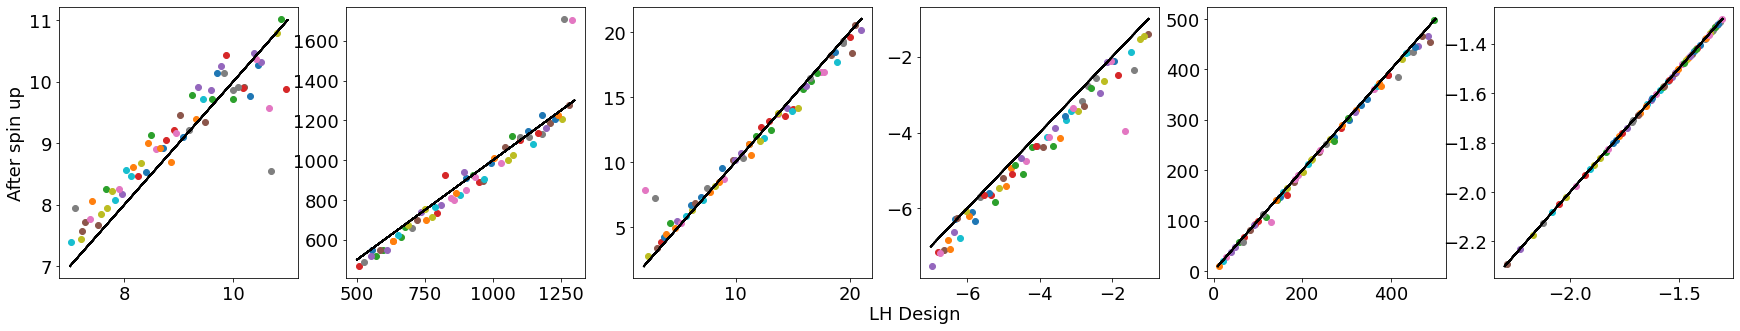

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(30,5))

t = 1
design = np.loadtxt("/home/users/eers/sct/lh_design/SCT_EmulatorInputsDesign.csv", skiprows=1, delimiter=',')
original=False
diff_dict = {'blqv': [(7, 11), np.empty((61))], 'bl_z': [(500, 1300), np.empty((61))], 'dtheta': [(2, 21), np.empty((61))], 
             'dqv': [(-7, -1), np.empty((61))], 'na': [(10, 500), np.empty((61))], 'baut': [(-2.3, -1.3), np.empty((61))]}

for i in range(61):
    if i!=40 and i!=56:
        ds = xr.open_dataset(f"/gws/nopw/j04/carisma/eers/sct/em/em{i}/sct_em{i}_merged.nc")

        if original==True:
            diff_dict['bl_z'][1][i] = get_blz(i, t)
            blz_ind = np.argmin(np.abs(ds.z.values - diff_dict['bl_z'][1][i]))
            diff_dict['blqv'][1][i] = get_blqv(ds, diff_dict['bl_z'][1][i], t)  
            diff_dict['dtheta'][1][i] = get_deltatheta(ds, diff_dict['bl_z'][1][i], t)
            diff_dict['dqv'][1][i] = get_deltaqv(ds, diff_dict['bl_z'][1][i], diff_dict['blqv'][1][i], t)
            diff_dict['na'][1][i] = get_na(ds, t)
            diff_dict['baut'][1][i] = get_baut(ds)
        else:
            dt_subcloud_top, dt_blz_ind, diff_dict['dtheta'][1][i] = get_deltheta_thresh(ds, t)
            dqv_subcloud_top, dqv_inv_ind, diff_dict['dqv'][1][i] = get_delqv_thresh(ds, t)
            diff_dict['bl_z'][1][i] = ds.zn[dt_blz_ind]
            diff_dict['blqv'][1][i] = ds.vapour_mmr_mean[t,5:dt_blz_ind].mean()*1e3
            diff_dict['na'][1][i] = get_na(ds, t) #ds.q_accum_sol_number[t,:,:,1:dt_blz_ind].mean().values*1e-6
            diff_dict['baut'][1][i] = get_baut(ds)

        for j,(key,val) in enumerate(diff_dict.items()):
            ax[j].scatter(design[i][j], val[1][i])
            ax[j].plot(val[0], val[0], c='black')

        ds.close()
        
ax[0].set_ylabel("After spin up")
fig.text(0.5,0.01,"LH Design")

In [51]:
fig.savefig("compare_spinup_thresholdvals.png")

In [6]:
np.savetxt("/home/users/eers/sct/lh_design/calculated_delth.csv", deltathe, delimiter=',')

### Plots showing the calculated subcloud top and transition top

In [27]:
ds = xr.open_dataset("/gws/nopw/j04/carisma/eers/sct/em/em0/sct_em0_merged.nc")
ds = cfl.ds_fix_dims(ds)

da = ds.theta_mean[0,5:]
da_q = ds.vapour_mmr_mean[0,5:]

m1 = min(da)
m2 = max(da)

q1 = min(da_q)
q2 = min(da_q)

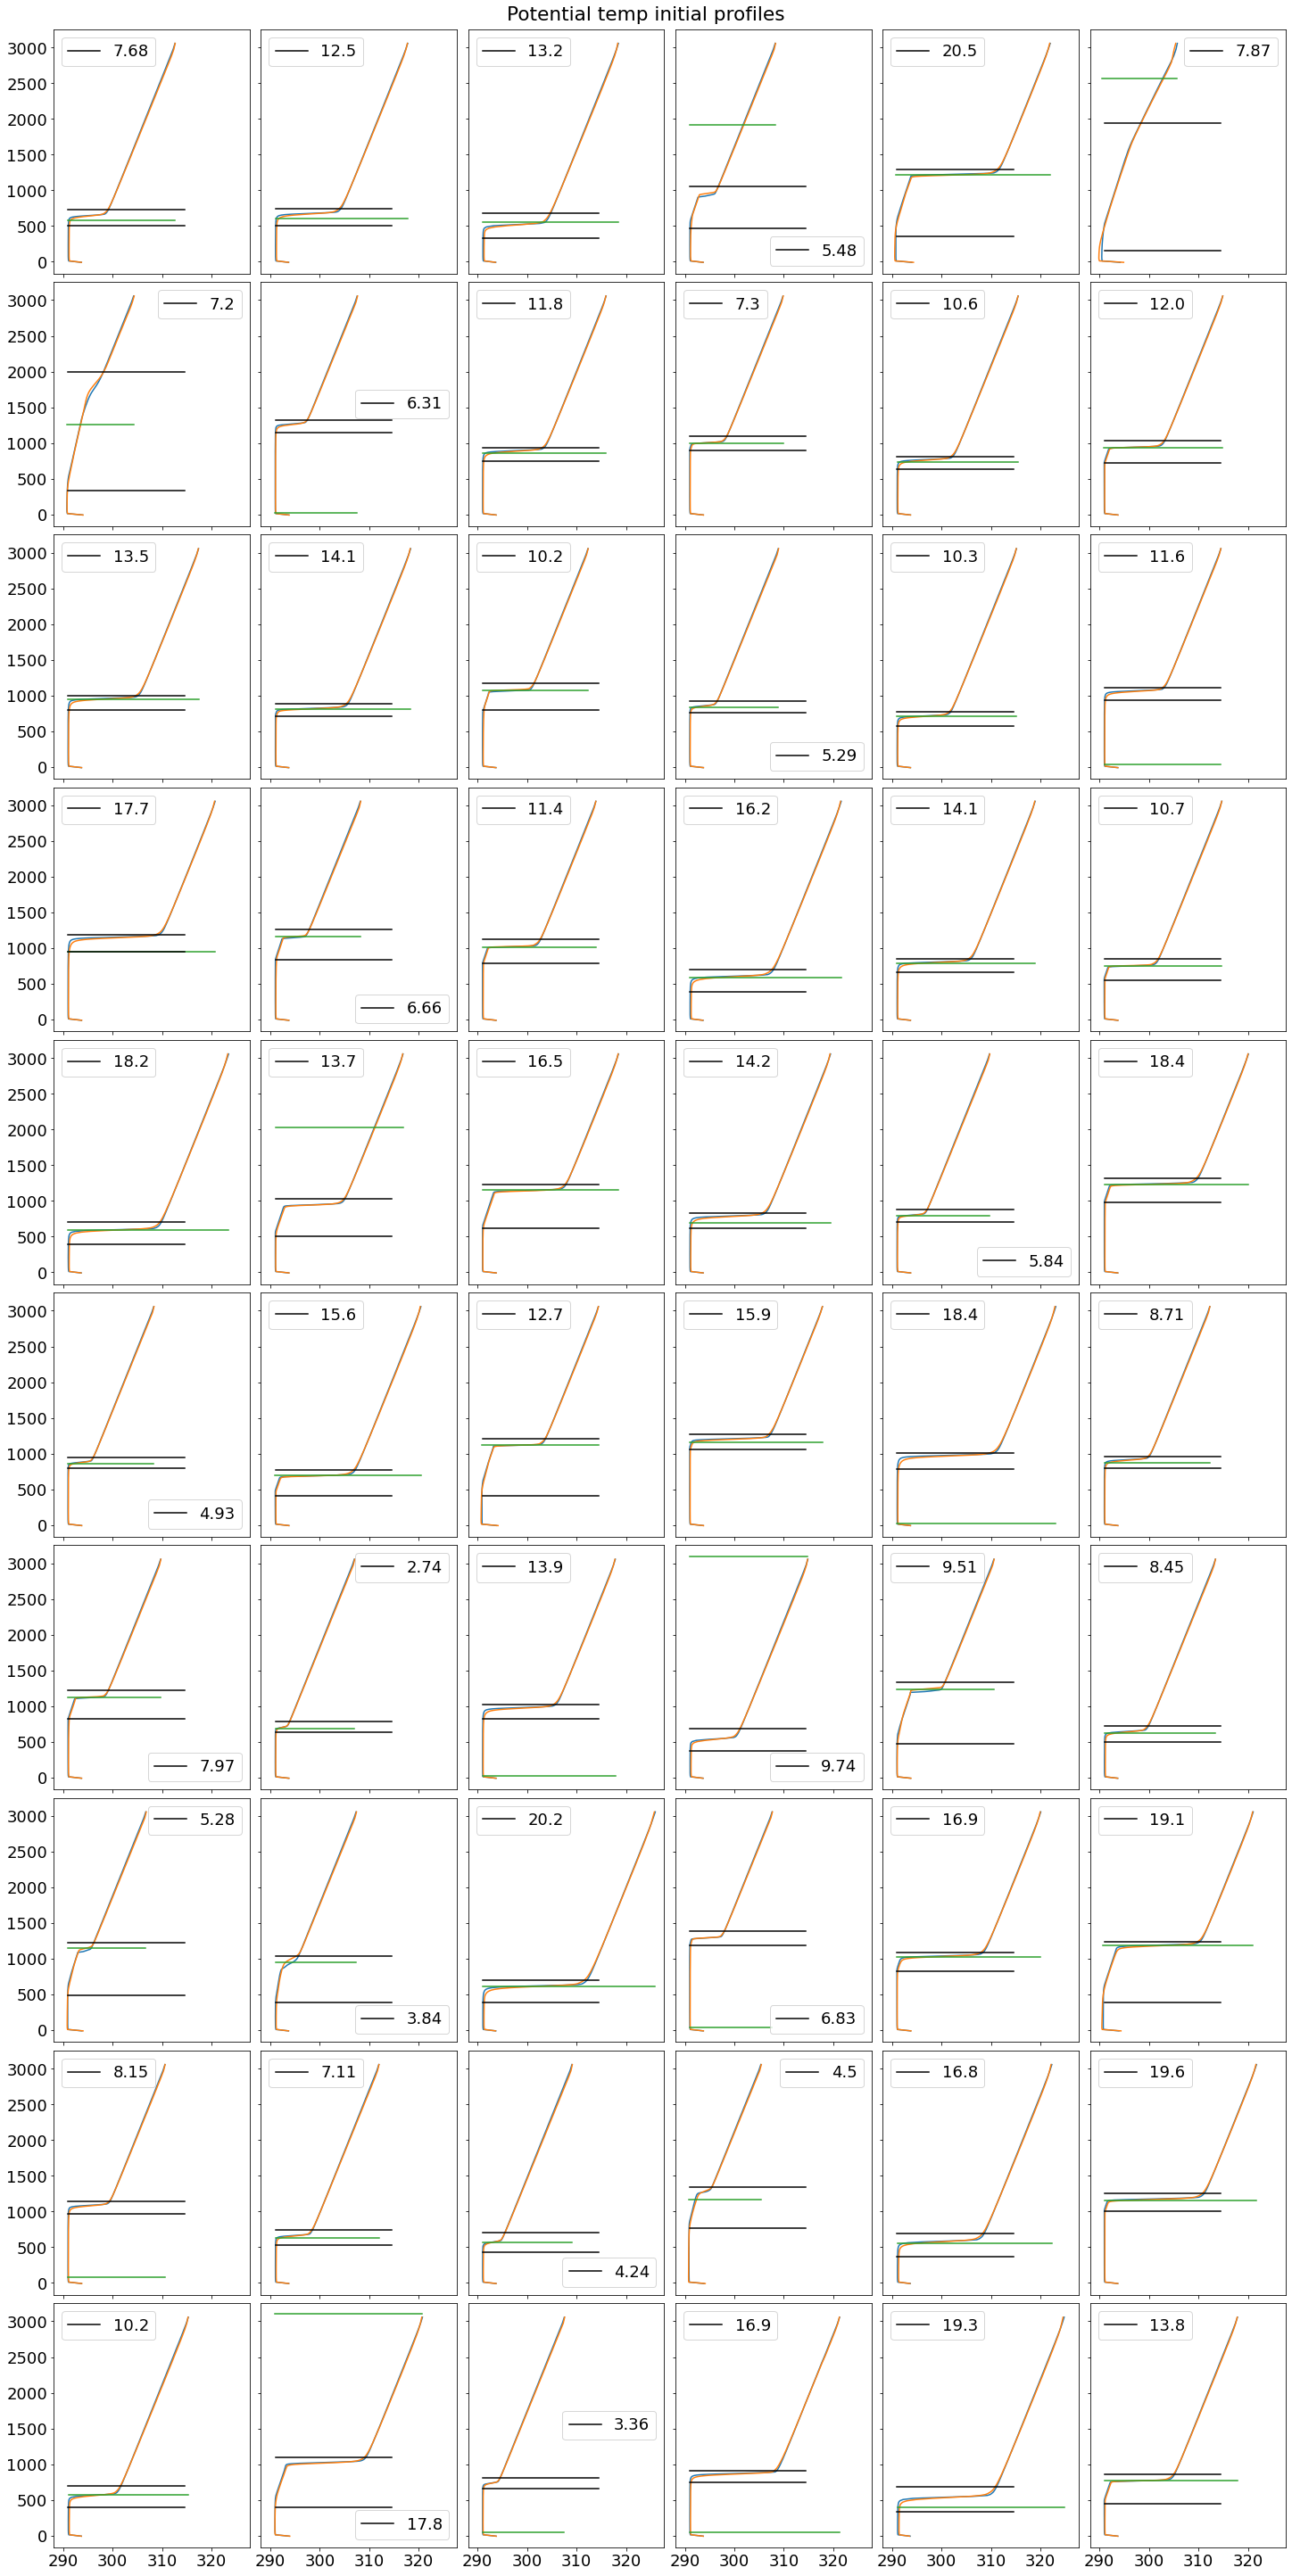

In [43]:
#fig, ax = plt.subplots(nrows=10,ncols=6, figsize=(25,40), sharex=True, sharey=True)
fig, ax = plt.subplots(nrows=10,ncols=6, figsize=(20,40), sharex=True, sharey=True, constrained_layout=True)

axes = []
for a in ax:
    for b in a:
        axes.append(b)
        
ind = 0
for a,b in zip(axes,range(1,61)):
    ds = xr.open_dataset(f'/gws/nopw/j04/carisma/eers/sct/em/em{b}/sct_em{b}_merged.nc')
    bl_z = get_blz(b, ind)
    blz_ind = np.argmin(np.abs(ds.z.values - bl_z))
    
    da=ds.theta_mean[1, 5:]
    ds.theta_mean[0].plot(y='zn', ax=a)
    ds.theta_mean[1].plot(y='zn', ax=a)
    a.plot((min(ds.theta_mean[ind]), max(ds.theta_mean[ind])), (bl_z, bl_z))
    #a.plot((min(ds.theta_mean[ind]), max(ds.theta_mean[ind])), (bl_z, bl_z))
    #ds.theta_mean[t, np.argmin(np.abs(ds.z.values - bl_z))]- ds.theta_mean[t, 1]
    
#     i=5
#     while np.abs(da[i] - np.mean(da[:i])) < 0.15 and i < len(ds.zn[5:-1]):
#         i+=1
    
#     grads1 = []
#     grads2 = []
#     for j in range(1,len(ds.zn[5:])):
#         g = (ds.zn.values[-1] - ds.zn.values[-1-j])/(da.values[-1] - da.values[-1-j])
#         grads1.append(np.abs(g))

#         g2 = (ds.zn.values[-j+1] - ds.zn.values[-j-1])/(da.values[-j+1] - da.values[-j-1])
#         grads2.append(np.abs(g2))

#     min_g_ind = np.argmin(grads1)
#     min_g_ind2 = np.argmin(grads2) 
    
#     #max_grad = np.argmax(np.gradient(da))

#     a.plot((m1, m2), (ds.zn[i], ds.zn[i]))
#     #a.plot((m1, m2), (ds.zn[inds[-1]], ds.zn[inds[-1]]))
#     a.plot((m1, m2), (ds.zn[-min_g_ind+20], ds.zn[-min_g_ind+20]), c='black')
#     #a.plot((m1, m2), (ds.zn[-min_g_ind2+15], ds.zn[-min_g_ind2+15]), c='blue')
#     #a.plot((m1, m2), (ds.zn[max_grad+5], ds.zn[max_grad+5]),lw=3)
    subcloud_top, inv_ind, diff = get_deltheta_thresh(ds, 1)
    a.plot((m1, m2), (ds.zn[subcloud_top], ds.zn[subcloud_top]), c='black')
    l,=a.plot((m1, m2), (ds.zn[inv_ind+20], ds.zn[inv_ind+20]), c='black', label=f'{diff:0.3}')
    a.set_title('')
    a.set_ylabel('')
    a.set_xlabel('')
    a.legend()
    
#fig.text(0.5,0.01,"Potential temperature (K)", ha='center', va='center')
#fig.text(0.01,0.5,"Height (m)", ha='center', va='center', rotation=90)
fig.suptitle("Potential temp initial profiles")
fig.savefig("pot_temp_profiles_inv_split.png")

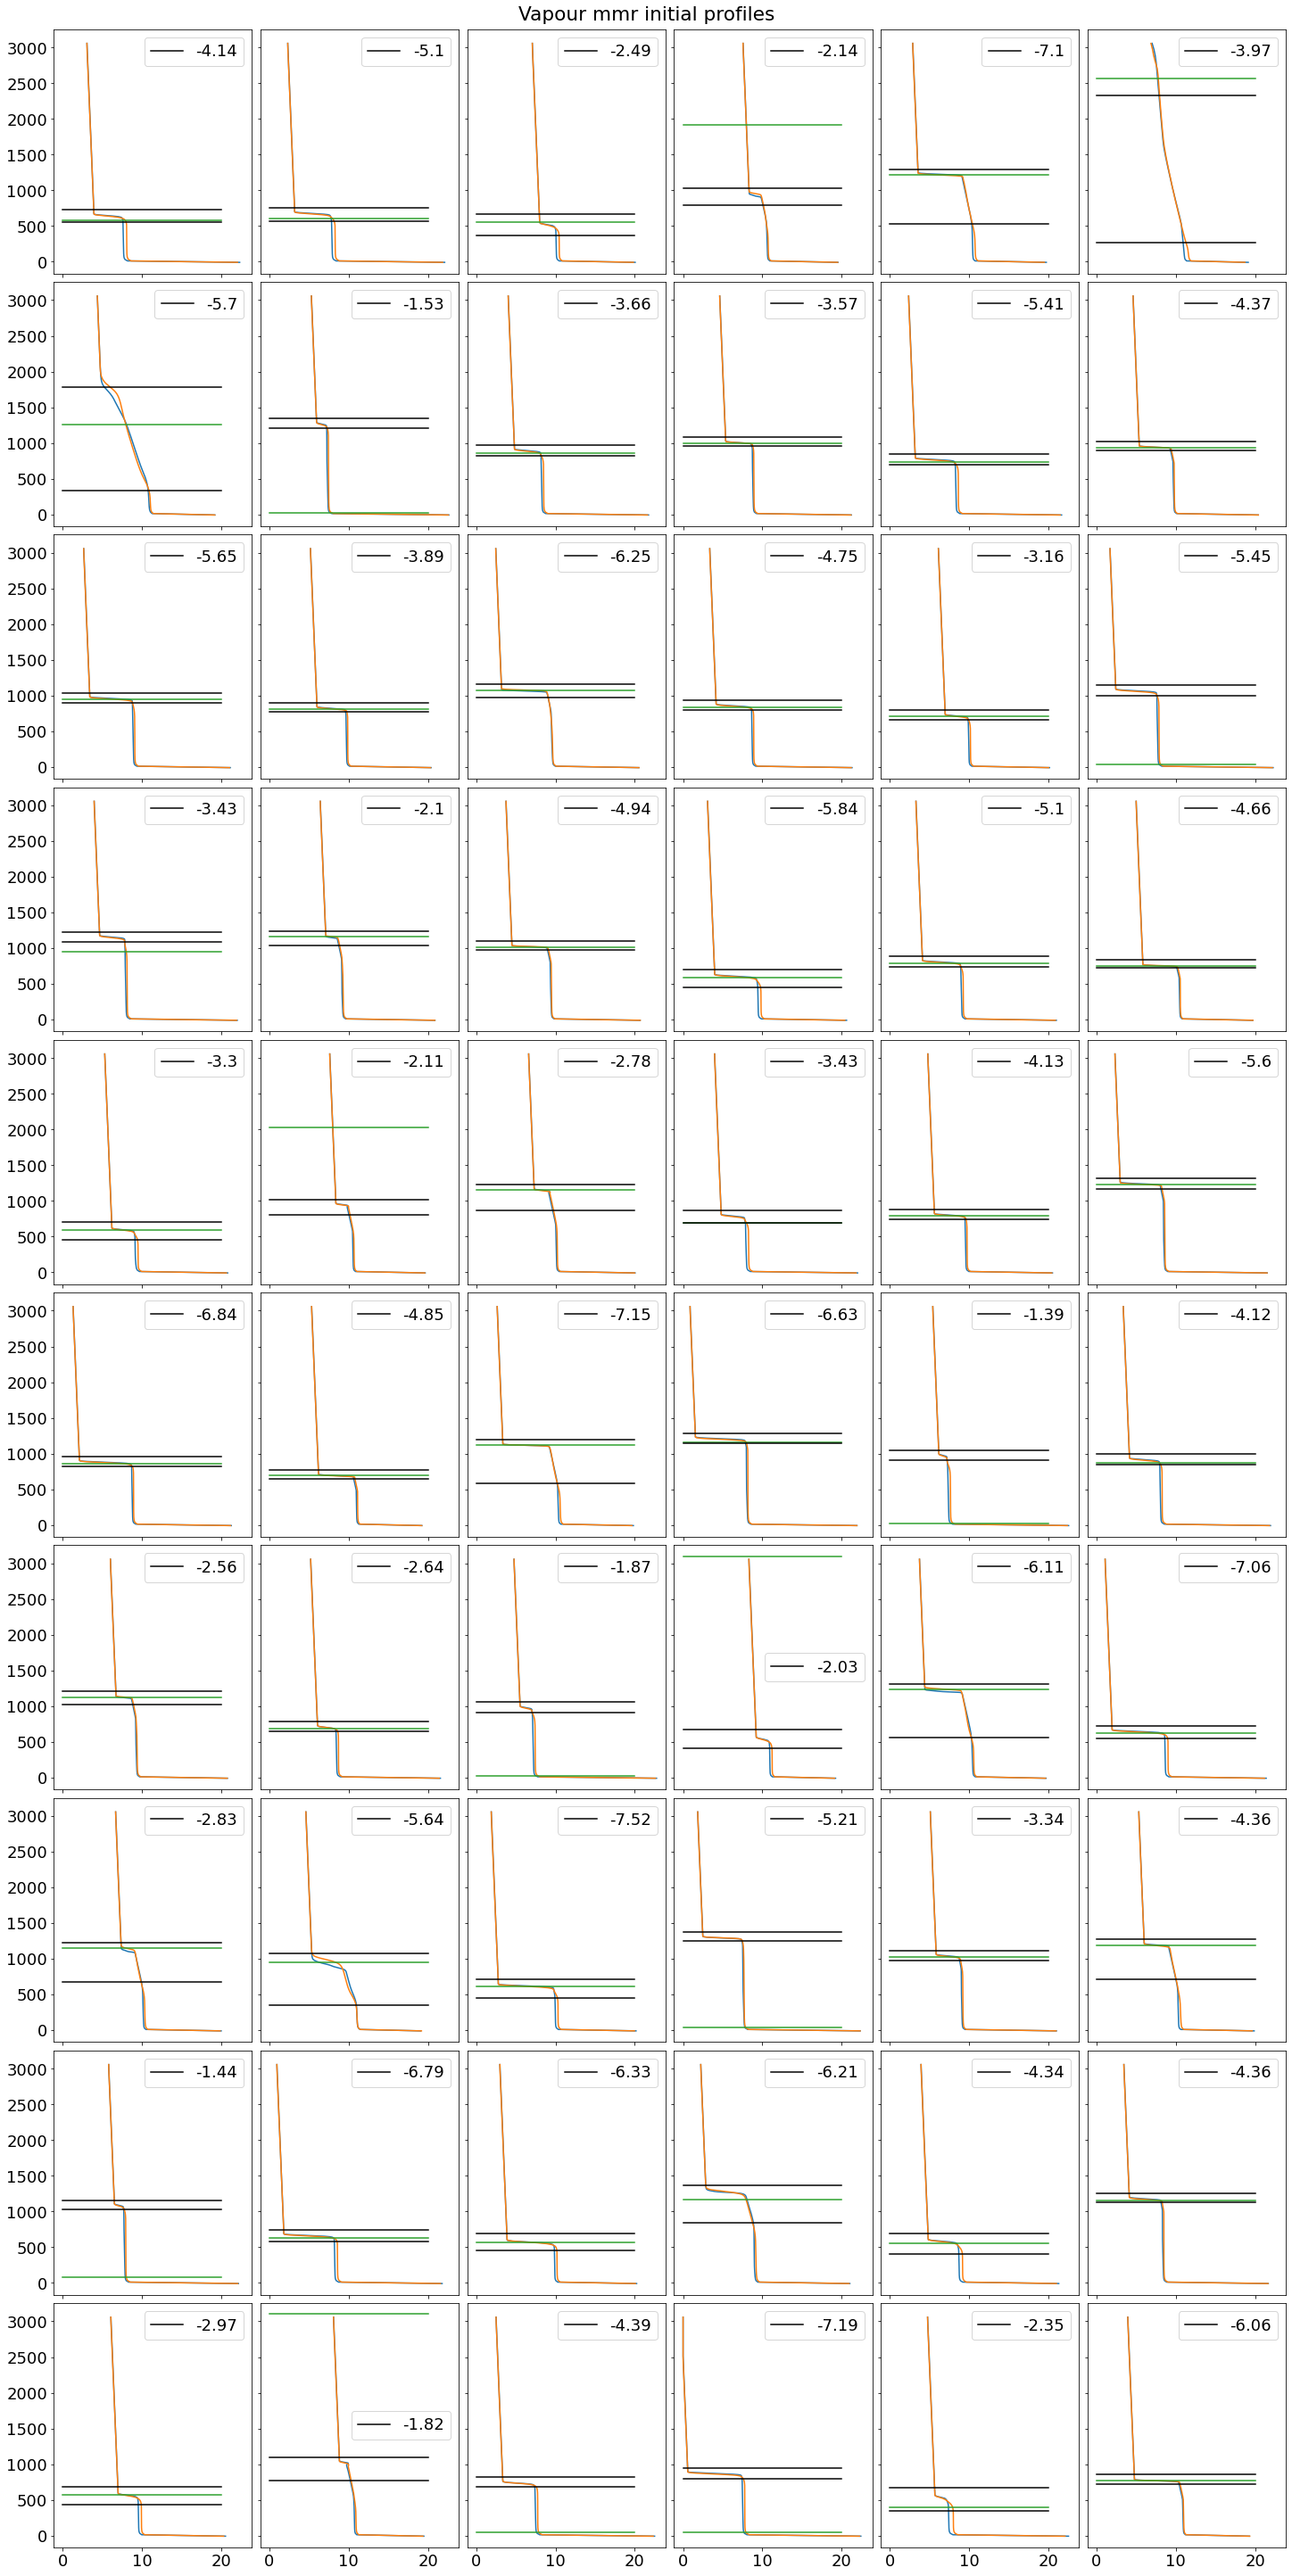

In [45]:
#fig, ax = plt.subplots(nrows=10,ncols=6, figsize=(25,50),sharex=True, sharey=True)
fig, ax = plt.subplots(nrows=10,ncols=6, figsize=(20,40), sharex=True, sharey=True, constrained_layout=True)

axes = []
for a in ax:
    for b in a:
        axes.append(b)

ind = 0
for a,b in zip(axes,range(1,61)):
    ds = xr.open_dataset(f'/gws/nopw/j04/carisma/eers/sct/em/em{b}/sct_em{b}_merged.nc')
    bl_z = get_blz(b, ind)
    blz_ind = np.argmin(np.abs(ds.z.values - bl_z))
    
    da_q = ds.vapour_mmr_mean[1,5:-2]*1e3
    zeroth=ds.vapour_mmr_mean[0]*1e3
    zeroth.plot(y='zn', ax=a)
    first=ds.vapour_mmr_mean[1]*1e3
    first.plot(y='zn', ax=a)
    a.plot((0,20), (bl_z, bl_z))
    #a.plot((min(ds.theta_mean[ind]), max(ds.theta_mean[ind])), (bl_z, bl_z))
    #ds.vapour_mmr_mean[t, np.argmin(np.abs(ds.z.values - bl_z))]- ds.vapour_mmr_mean[t, 1]
    
#     subcloud_top=5
#     while np.abs(da_q[subcloud_top] - np.mean(da_q[:subcloud_top])) < 0.35e-3 and subcloud_top < len(ds.zn[5:-1]):
#         subcloud_top+=1
    
# #     grads1 = []
# #     grads2 = []
# #     for j in range(1,len(ds.zn[5:])):
# #         g = (ds.zn.values[-1] - ds.zn.values[-1-j])/(da.values[-1] - da.values[-1-j])
# #         grads1.append(np.abs(g))

# #         g2 = (ds.zn.values[-j+1] - ds.zn.values[-j-1])/(da.values[-j+1] - da.values[-j-1])
# #         grads2.append(np.abs(g2))

# #     min_g_ind = np.argmin(grads1)
# #     min_g_ind2 = np.argmin(grads2) 
    
#     min_grad = np.argmin(np.gradient(da_q.values))
    
#     #a.plot((q1, q2), (ds.zn[inds[-1]], ds.zn[inds[-1]]))
#     #a.plot((m1, m2), (ds.zn[-min_g_ind], ds.zn[-min_g_ind]),alpha=0.2)
#     #a.plot((m1, m2), (ds.zn[-min_g_ind2], ds.zn[-min_g_ind2]),alpha=0.2)
#     if b in [6,7]:
#         ft_ind = min_grad
#     else:
#         ft_ind = min_grad+20
    
#     diff = da_q[ft_ind] - da_q[:subcloud_top].mean()

    subcloud_top, min_grad, diff = get_delqv_thresh(ds, 1)
    
    if min_grad < 240:
        inv_ind = min_grad+20
    else:
        inv_ind = min_grad
    
    a.plot((0,20), (ds.zn[subcloud_top], ds.zn[subcloud_top]), c='black')
    a.plot((0,20), (ds.zn[inv_ind], ds.zn[inv_ind]),c='black', label=f'{diff:0.3}')
    a.set_title('')
    a.set_xlabel('')
    a.set_ylabel('')
    a.legend()
    
#fig.text(0.5,0.01,"Vapour mmr (g/kg)", ha='center', va='center')
#fig.text(0.01,0.5,"Height (m)", ha='center', va='center', rotation=90)
fig.suptitle("Vapour mmr initial profiles")
fig.savefig("vap_mmr_profiles_inv_split.png")

In [ ]:
#### All of the below can be deleted. Workings for the delta theta and delta qv

In [182]:
thresh1 = 0.01
thresh2 = 0.033
means = []
inds = []
jumps = []
for i in range(len(ds.zn)):
    means.append(np.mean(da[i+0:i+5]))
    if i!=0:
        diff=np.abs(means[i]-means[i-1])
        #print(diff.values)
        if diff > 0.001*means[i-1]:
            if len(inds)!=0 and np.abs(i - inds[-1]) > 1:
                jumps.append(inds[-1])
                jumps.append(i)
            inds.append(i)
            if diff > thresh2:
                #if len(inds)!=0 and np.abs(i - inds[-1]) > 1:
                jumps.append(i)

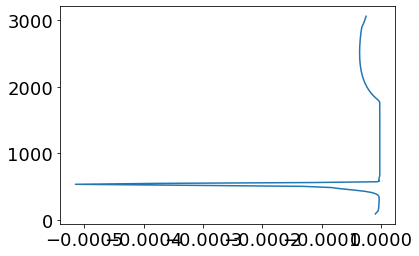

In [389]:
fig,ax = plt.subplots()
ax.plot(np.gradient(ds.vapour_mmr_mean[0,5:].values), ds.zn[5:])
#da.plot(ax=ax, y='zn')

[208.5314517946529, 192.3829828853357, 185.9690139370655, 182.70586145522225, 180.75556855067765, 179.46773955259619, 178.561150964068, 177.89499268027564, 177.39029648726853, 177.00209459155764, 176.70188058694274, 176.4697698621958, 176.29250397551579, 176.1597670159539, 176.06215330357932, 175.99230496940106, 175.94331736158864, 175.90895752088667, 175.88420070641413, 175.86526024670087, 175.8495912009409, 175.83565358614828, 175.82260676078187, 175.8100212071401, 175.7976842926853, 175.7854937050571, 175.77340144113487, 175.76138501202516, 175.74943170694178, 175.7375347305283, 175.7256950923041, 175.7139132439144, 175.7021889487578, 175.69052153835824, 175.67891011280787, 175.66735362724907, 175.65585093749345, 175.64440385761216, 175.63301151948315, 175.62167163371507, 175.61038206390262, 175.59914096131484, 175.5879468113229, 175.576798277907, 175.56569430985704, 175.55463380515454, 175.54362418957848, 175.5326678750372, 175.52175991556223, 175.51089411894267, 175.50006547217333

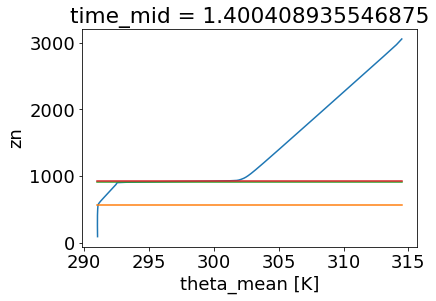

In [371]:
fig, ax = plt.subplots()
da.plot(y='zn',ax=ax)

inds1 = []
for i in range(len(ds.zn[5:-1])):
    #print(np.abs(da[i] - np.mean(da[:i])).values)
    if np.abs(da[i] - np.mean(da[:i])) > 0.15:
        inds1.append(i)
        
#print(inds)
#print(da[inds].values)
ax.plot((m1, m2), (ds.zn[inds1[0]], ds.zn[inds1[0]]))

inds2 = []
grads1 = []
grads2 = []
for i in range(1,len(ds.zn[5:])):
    g = (ds.zn.values[-1] - ds.zn.values[-1-i])/(da.values[-1] - da.values[-1-i])
    grads1.append(np.abs(g))

    g2 = (ds.zn.values[-i+1] - ds.zn.values[-i-1])/(da.values[-i+1] - da.values[-i-1])
    grads2.append(np.abs(g2))

    #means = np.mean(grads)
    #print(means)
    if len(grads)>1 and np.abs(g - grads[-1]) > 0.2:
        inds2.append(i)
#     

min_g_ind = np.argmin(grads1)
min_g_ind2 = np.argmin(grads2)
print(grads1)
#     if  < 170:
#         inds2.append(i)
# for i in range(len(ds.zn[5:-1]),2,-1):
#     #print(np.abs(da[i] - np.mean(da[i:])).values)
#     if np.abs(da[i] - np.mean(da[i:])) < 3:
#         inds2.append(i)        

#print(inds2)
# for i in inds2:
#     ax.plot((m1, m2), (ds.zn[i], ds.zn[i]), alpha=0.2)

# inds = []
# for i in range(len(ds.zn[5:-1])):
#     #print(np.abs(da_q[i] - np.mean(da_q[:i])).values)
#     if np.abs(da_q[i] - np.mean(da_q[:i])) > 1e-3:
#         inds.append(i)
        
ax.plot((m1, m2), (ds.zn[-min_g_ind], ds.zn[-min_g_ind]))
ax.plot((m1, m2), (ds.zn[-min_g_ind2], ds.zn[-min_g_ind2]))

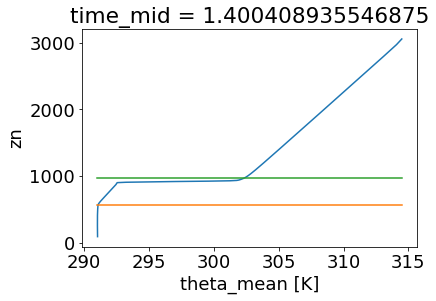

In [316]:
fig, ax = plt.subplots()
da.plot(y='zn',ax=ax)

i=5
while np.abs(da[i] - np.mean(da[:i])) < 0.15 and i < len(ds.zn[5:-1]):
    i+=1
    
inds = []
for j in range(len(ds.zn[5:-1]),2,-1):
    if np.abs(da[j] - np.mean(da[j:])) < 3:
        inds.append(j)  
    
ax.plot((m1, m2), (ds.zn[i], ds.zn[i]))
ax.plot((m1, m2), (ds.zn[inds[-1]], ds.zn[inds[-1]]))

In [250]:
inds = []
for i in range(len(ds.zn[2:-25]),2,-1):
    if (ds.zn[i] - ds.zn[i-1])/(da[i] - da[i-1]) < 170:
        inds.append(i)
        
print(inds)

[143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]


In [183]:
print(inds)
print(da.values[jumps])
print(jumps)
#print(jumps[np.where(np.asarray(jumps)>5)[0]])

print(da.values[jumps[np.where(np.asarray(jumps)>5)[0]-1]],da.values[jumps[np.where(np.asarray(jumps)>5)[0]]],da.values[jumps[-1]+1])
bl_mean = np.mean(da.values[jumps[np.where(np.asarray(jumps)>5)[0]-1]:jumps[np.where(np.asarray(jumps)>5)[0]]])
print( da.values[jumps[-1]+1] - bl_mean)

[1, 83, 84, 85, 86, 87, 88, 89, 90, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260]
[291.10113346 291.10113346 292.49683804 292.49683804 292.51268788
 292.56475006 293.21538391 294.88181291 296.96267658 299.55884736
 301.21986203 301.21986203 307.87398231 307.87398231 308.14630581
 308.48354594 308.88292244 309.33660767 309.83345285 310.36100288
 310.90723149 311.46151983 312.0147777  312.55943375]
[1, 1, 83, 83, 84, 85, 86, 87, 88, 89, 90, 90, 250, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260]


TypeError: only integer scalar arrays can be converted to a scalar index

(array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 2

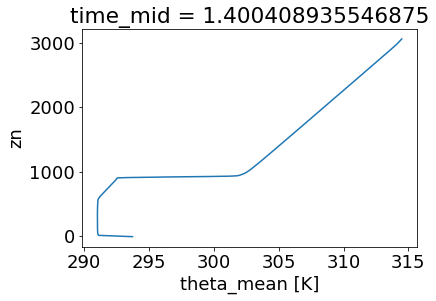

In [94]:
fig, ax = plt.subplots()
da.plot(y='zn',ax=ax)

mask = np.ones(da.values.size, dtype=bool)
mask[inds] = 0
m_arr = np.ma.masked_array(da.values[1:], mask=mask[1:])
inds = np.where(m_arr.mask==True)
print([abs([i]) ])
# result = da.values[mask]
# diff = [np.abs(m_arr[i] - m_arr[i-1]) for i in range(1,len(m_arr))]
# print(diff)
# jump = np.where(np.asarray(diff)>1)
# bl = jump[0]+1
# ft = jump[0]+2

# print(bl, ft)
# for i in inds:
#     ax.plot((m1, m2), (ds.zn[bl], ds.zn[bl]))
#     ax.plot((m1, m2), (ds.zn[ft], ds.zn[ft]))

In [76]:
mask = np.ones(da.values.size, dtype=bool)
mask[inds] = False
result = da.values[mask]
diff = [np.abs(result[i] - result[i-1]) for i in range(2,len(result))]
print(diff)
jump = np.where(np.asarray(diff)>1)
print(result[jump[0]+1],result[jump[0]+2])

[0.0066474089659323, 0.0034254349614570856, 0.0020071426845333917, 0.0013853016321832001, 0.0010773436036402018, 0.000948567774400999, 0.0009173752197284557, 0.0008967768652041741, 0.0008593525010383019, 0.0007837395481260501, 0.0006110039354325636, 0.0004223391601385629, 0.00025768026705463853, 1.0770614210287022e-05, 0.0003347715900758885, 0.0007660521357024663, 0.0012572887628721219, 0.0018073998489853693, 0.0024107829592026064, 0.003006664363283562, 0.0035487985861095694, 0.004079682486519687, 0.004548282802431913, 0.004512256492375855, 11.429517575420789, 0.04587605243472126, 0.04375434363419117, 0.042056954826136916, 0.040681799946469255, 0.039572104115507045, 0.03865452740382125, 0.03789168180452407, 0.03725134731877233, 0.03670887459628602, 0.036245185583254624, 0.03584524880415074, 0.03549683730528841, 0.03519155194396717, 0.034922293843806074, 0.034683283183142066, 0.03447000449779125, 0.03427888588277028, 0.034106968736409726, 0.033951733213086754, 0.03381117496559227, 0.033